# Image Classification Using Convnet & Augmented Data

## Libraries & Functions

In [1]:
import pandas as pd
import numpy as np
import itertools
import sys

import keras
from keras import layers
from keras import models
from keras.models import load_model

from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras import optimizers
from keras import applications
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec
%matplotlib inline
import math

In [2]:
def conv3264128_dense512_do():
    """
    Function to define a model which consist of convolutional networks or 32, 64 and 128 channels
    and dense layers of 512 & 4
    Inclduing a dropout regularisation of 0.5
    """
    model = Sequential()
    model.add(Conv2D(32, 
                     (3, 3), 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', 
                     input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())     
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(4, activation='softmax'))
   
    # compile model
    opt = optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def show_raw_image(img_file):
    """
    Function to display raw image.
    Input : img_file ='path to the image file'
    """
    image = imread(img_file)
    pyplot.imshow(image)
    pyplot.show()   
    
def one_img_prep(img_path):
    """
    Function to preprocess one single image, to rescale/resize.
    Input: path to the image file 
    Output: image shape (1, 224, 224, 3)
    """
    img = image.load_img(img_file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis =0)
    x /= 255.
    return x

def print_pred_class(pred):
    """
    Function to print the predicted class and probability distribution of each class.
    Input: pred = model.predict(x) where x is a pre-preprocessed image 
    
    """
    pred = pred
    pred_class = np.argmax(pred[0])
    print("Predicted class probabilities:",'\n'\
          "Class 0 - city run      : %2.2f" % pred[0][0],'\n'\
          "Class 1 - park run      : %2.2f" % pred[0][1],'\n'\
          "Class 2 - riverside run : %2.2f" % pred[0][2],'\n'\
          "Class 3 - seaside run   : %2.2f" % pred[0][3],'\n\n'\
          "Highest pred probability: Class %2.0f" %np.argmax(pred[0]))

## Neural Network with Data Augmentation generators 

In [3]:
# define model
model = conv3264128_dense512_do()

In [4]:
# train and test data 
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 10,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.1,
                                   shear_range = 0.25,
                                   zoom_range = 0.5,
                                   horizontal_flip = False)
val_datagen = ImageDataGenerator(rescale = 1.0/255)

In [5]:
train_generator = train_datagen.flow_from_directory('running_routes/train/',
                                                    class_mode = 'categorical', 
                                                    batch_size = 30, 
                                                    target_size = (224, 224), 
                                                    shuffle=False)
val_generator = val_datagen.flow_from_directory('running_routes/val/',
                                                class_mode = 'categorical', 
                                                batch_size = 10, 
                                                target_size = (224, 224), 
                                                shuffle=False)

Found 321 images belonging to 4 classes.
Found 79 images belonging to 4 classes.


In [6]:
history = model.fit(train_generator, 
                    steps_per_epoch = len(train_generator),
                    validation_data=val_generator, 
                    validation_steps=len(val_generator), 
                    epochs = 10, 
                    verbose = 0)

In [7]:
# Uncomment to save the model
#model.save('cnn_augmentation_10.h5')

In [8]:
eval_loss, eval_accuracy = model.evaluate(val_generator, steps=len(val_generator), verbose=0)
print('Accuracy: {:.2f}%'.format(eval_accuracy*100))
print('Loss: {:.2f}%'.format(eval_loss))

Accuracy: 31.65%
Loss: 1.25%


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [58]:
#model = load_model('cnn_augmentation_10.h5')

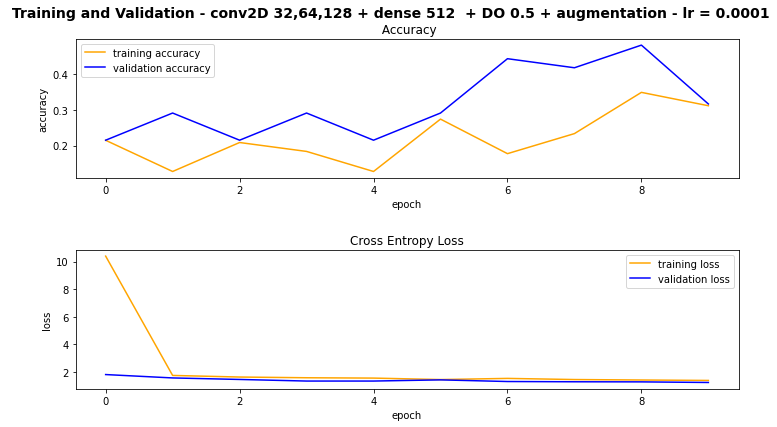

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


#fig,axes = plt.subplots(ncols = 2, figsize =(10,4))
fig, (ax1, ax2) = plt.subplots(2)
# to change size of subplot's  
fig.set_figheight(6) 
fig.set_figwidth(10) 
  
# create grid for different subplots 
spec = gridspec.GridSpec(ncols=1, nrows=2, 
                         width_ratios=[1], wspace=1, 
                         hspace=5, height_ratios=[1, 2]) 

fig.suptitle(' Training and Validation - conv2D 32,64,128 + dense 512  + DO 0.5 + augmentation - lr = 0.0001\n', 
             fontsize=14,
             weight = 'bold')

ax1.plot(epochs, acc, 'orange', label = 'training accuracy')
ax1.plot(epochs, val_acc, 'b', label = 'validation accuracy')
ax1.set_title('\n Accuracy')
ax1.set(xlabel = 'epoch', ylabel = 'accuracy')
ax1.plot
ax1.legend()


ax2.plot(epochs, loss, 'orange', label = 'training loss')
ax2.plot(epochs, val_loss, 'b', label = 'validation loss')
ax2.set_title('\nCross Entropy Loss')
ax2.set(xlabel = 'epoch', ylabel = 'loss')
ax2.legend()

fig.tight_layout(pad = 1.0)

#plt.savefig('results/cnn_augmented_10.png', dpi=200)
plt.show()

In [11]:
#model = load_model('cnn_augmentation_10.h5'')

In [60]:
Y_pred_aug_val = model.predict(val_generator, steps=len(val_generator))
y_pred_aug_val = np.argmax(Y_pred_aug_val, axis=1)

In [61]:
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())  

In [62]:
augmented_confusion = metrics.confusion_matrix(val_generator.classes, y_pred_aug_val)
augmented_confusion

array([[ 0,  0, 23,  0],
       [ 0,  2, 18,  0],
       [ 0,  0, 17,  0],
       [ 0,  0,  8, 11]])

Text(0.5, 1.0, 'Confusion Matrix - Validation \nConv 32, 64, 128 + dense 512 + data augmentation')

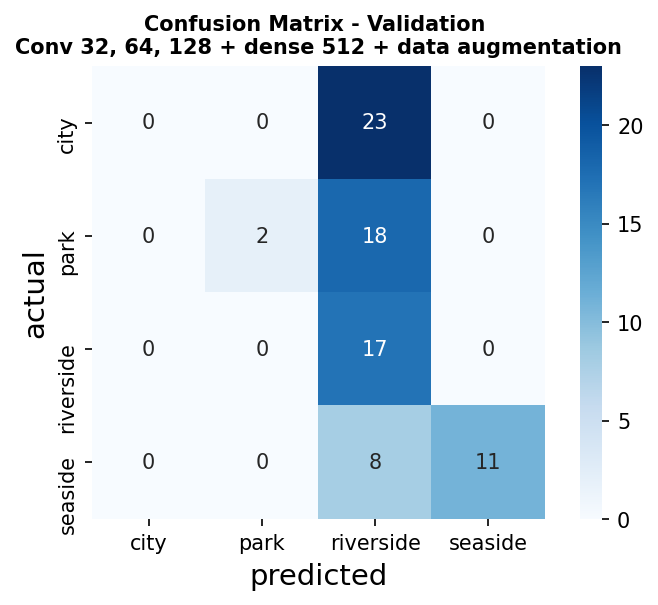

In [63]:
plt.figure(dpi=150)
sns.heatmap(augmented_confusion, cmap=plt.cm.Blues, annot=True, square=True, 
            xticklabels=['city','park', 'riverside', 'seaside'],
            yticklabels=['city','park', 'riverside', 'seaside'],
            fmt = ",.0f");
plt.xlabel('predicted', fontsize = 14)
plt.ylabel('actual', fontsize = 14)
plt.title('Confusion Matrix - Validation \nConv 32, 64, 128 + dense 512 + data augmentation', fontsize = 10, fontweight = 'bold')
#plt.savefig('val_cnn_aug_10.png')

In [64]:
aug_val_report = metrics.classification_report(true_classes, y_pred_aug_val, target_names=class_labels)
print(aug_val_report)   

               precision    recall  f1-score   support

     city_run       0.00      0.00      0.00        23
     park_run       1.00      0.10      0.18        20
riverside_run       0.26      1.00      0.41        17
  seaside_run       1.00      0.58      0.73        19

     accuracy                           0.38        79
    macro avg       0.56      0.42      0.33        79
 weighted avg       0.55      0.38      0.31        79



/Users/carlamoestafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fit the final train (train + val) data 

In [65]:
finaltrain_datagen = train_datagen
test_datagen = val_datagen

In [66]:
finaltrain_generator = finaltrain_datagen.flow_from_directory('running_routes/final_train/',
                                                    class_mode = 'categorical', 
                                                    batch_size = 30, 
                                                    target_size = (224, 224), 
                                                    shuffle=False)
test_generator = test_datagen.flow_from_directory('running_routes/test/',
                                                class_mode = 'categorical', 
                                                batch_size = 10, 
                                                target_size = (224, 224), 
                                                shuffle=False)

Found 400 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [67]:
nb_test_samples = len(test_generator.filenames)
num_classes = len(test_generator.class_indices)
test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes =num_classes)

In [68]:
nb_finaltrain_samples = len(finaltrain_generator.filenames)
num_classes = len(finaltrain_generator.class_indices)
finaltrain_labels = finaltrain_generator.classes
finaltrain_labels = to_categorical(finaltrain_labels, num_classes =num_classes)

In [69]:
model.fit(finaltrain_generator, 
          steps_per_epoch=len(finaltrain_generator),epochs = 10,
          verbose = 1)

Epoch 1/10
14/14 [==============================] - 31s 2s/step - loss: 1.4024 - accuracy: 0.3200
Epoch 2/10
14/14 [==============================] - 37s 3s/step - loss: 1.3581 - accuracy: 0.2650
Epoch 3/10
14/14 [==============================] - 30s 2s/step - loss: 1.3200 - accuracy: 0.2750
Epoch 4/10
14/14 [==============================] - 30s 2s/step - loss: 1.2075 - accuracy: 0.4250
Epoch 5/10
14/14 [==============================] - 30s 2s/step - loss: 1.2403 - accuracy: 0.3275
Epoch 6/10
14/14 [==============================] - 29s 2s/step - loss: 1.1848 - accuracy: 0.4375
Epoch 7/10
14/14 [==============================] - 29s 2s/step - loss: 1.1302 - accuracy: 0.4250
Epoch 8/10
14/14 [==============================] - 29s 2s/step - loss: 1.1802 - accuracy: 0.4675
Epoch 9/10
14/14 [==============================] - 33s 2s/step - loss: 1.1154 - accuracy: 0.4625
Epoch 10/10
14/14 [==============================] - 30s 2s/step - loss: 1.0903 - accuracy: 0.5025


## Test the model

In [70]:
Y_test_pred = model.predict(test_generator, steps=len(test_generator))
y_test_pred = np.argmax(Y_test_pred, axis=1)
test_true_classes = test_generator.classes
test_class_labels = list(test_generator.class_indices.keys())  

In [71]:
test_confusion = metrics.confusion_matrix(test_true_classes, y_test_pred)
test_confusion

array([[13,  6,  5,  1],
       [ 3, 16,  6,  0],
       [ 4,  3,  7, 11],
       [ 0,  1,  0, 24]])

Text(0.5, 1.0, 'Confusion Matrix - Test \nConv 32, 64, 128 + dense 512 + DO + Augmentation')

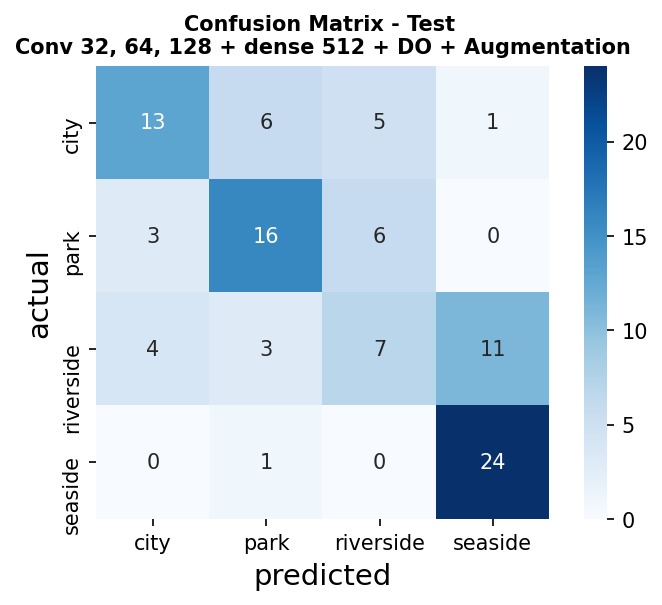

In [72]:
plt.figure(dpi=150)
sns.heatmap(test_confusion, cmap=plt.cm.Blues, annot=True, square=True, 
            xticklabels=['city','park', 'riverside', 'seaside'],
            yticklabels=['city','park', 'riverside', 'seaside'],
            fmt = ",.0f");
plt.xlabel('predicted', fontsize = 14)
plt.ylabel('actual', fontsize = 14)
plt.title('Confusion Matrix - Test \nConv 32, 64, 128 + dense 512 + DO + Augmentation', fontsize = 10, fontweight = 'bold')
#plt.savefig('results/test_cnn_aug_10.png')

In [73]:
report = metrics.classification_report(test_true_classes, y_test_pred, target_names=class_labels)
print(report)    

               precision    recall  f1-score   support

     city_run       0.65      0.52      0.58        25
     park_run       0.62      0.64      0.63        25
riverside_run       0.39      0.28      0.33        25
  seaside_run       0.67      0.96      0.79        25

     accuracy                           0.60       100
    macro avg       0.58      0.60      0.58       100
 weighted avg       0.58      0.60      0.58       100



In [74]:
report_dict = report = metrics.classification_report(test_true_classes, 
                                                     y_test_pred, 
                                                     target_names=class_labels, 
                                                     output_dict = True)
print(report_dict)  

{'city_run': {'precision': 0.65, 'recall': 0.52, 'f1-score': 0.5777777777777778, 'support': 25}, 'park_run': {'precision': 0.6153846153846154, 'recall': 0.64, 'f1-score': 0.6274509803921569, 'support': 25}, 'riverside_run': {'precision': 0.3888888888888889, 'recall': 0.28, 'f1-score': 0.32558139534883723, 'support': 25}, 'seaside_run': {'precision': 0.6666666666666666, 'recall': 0.96, 'f1-score': 0.7868852459016393, 'support': 25}, 'accuracy': 0.6, 'macro avg': {'precision': 0.5802350427350427, 'recall': 0.6000000000000001, 'f1-score': 0.5794238498551029, 'support': 100}, 'weighted avg': {'precision': 0.5802350427350427, 'recall': 0.6, 'f1-score': 0.5794238498551028, 'support': 100}}


In [75]:
df = pd.DataFrame(report_dict).transpose()

In [76]:
df

,precision,recall,f1-score,support
city_run,0.650000,0.52,0.577778,25.0
park_run,0.615385,0.64,0.627451,25.0
riverside_run,0.388889,0.28,0.325581,25.0
seaside_run,0.666667,0.96,0.786885,25.0
accuracy,0.600000,0.60,0.600000,0.6
macro avg,0.580235,0.60,0.579424,100.0
weighted avg,0.580235,0.60,0.579424,100.0


In [29]:
#df.to_csv('results/test_cnn_aug_10.csv')

### Examples of image classification & prediction

In [77]:
#paths to single images:
path_1 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/city_run/city_95.png'
path_2 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/city_run/city_125.png'
path_3 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/park_run/park_5.png'
path_4 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/park_run/park_109.png'
path_5 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/riverside_run/river_8.png'
path_6 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/riverside_run/river_89.png'
path_7 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/seaside_run/seaside_65.png'
path_8 = '//Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/seaside_run/seaside_47.png'

In [78]:
img_file = path_1
x1 = one_img_prep(img_file)

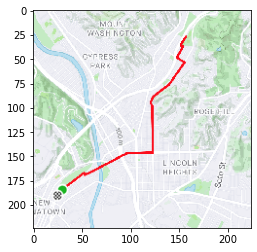

In [79]:
plt.imshow(x1[0])

In [80]:
pred_1 = model.predict(x1)
pred = pred_1
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.32 
Class 1 - park run      : 0.28 
Class 2 - riverside run : 0.30 
Class 3 - seaside run   : 0.10 

Highest pred probability: Class  0


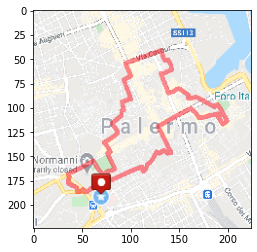

In [81]:
img_file = path_2
x2 = one_img_prep(img_file)
plt.imshow(x2[0])

In [82]:
pred_2 = model.predict(x2)
pred = pred_2
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.39 
Class 1 - park run      : 0.26 
Class 2 - riverside run : 0.29 
Class 3 - seaside run   : 0.06 

Highest pred probability: Class  0


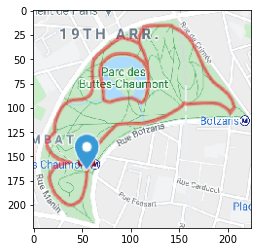

In [83]:
img_file = path_3
x3 = one_img_prep(img_file)
plt.imshow(x3[0])

In [84]:
pred_3 = model.predict(x3)
pred = pred_3
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.31 
Class 1 - park run      : 0.35 
Class 2 - riverside run : 0.26 
Class 3 - seaside run   : 0.08 

Highest pred probability: Class  1


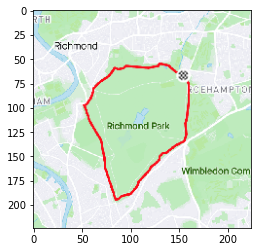

In [85]:
img_file = path_4
x4 = one_img_prep(img_file)
plt.imshow(x4[0])

In [86]:
img = image.load_img(path_4, target_size=(224, 224))
x4 = image.img_to_array(img)
x4 = np.expand_dims(x4, axis =0)
x4 /= 255.
pred_4 = model.predict(x4)
pred = pred_4
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.29 
Class 1 - park run      : 0.42 
Class 2 - riverside run : 0.22 
Class 3 - seaside run   : 0.08 

Highest pred probability: Class  1


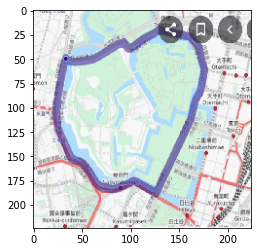

In [87]:
img_file = path_5
x5 = one_img_prep(img_file)
plt.imshow(x5[0])

In [88]:
pred_5 = model.predict(x5)
pred = pred_5
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.18 
Class 1 - park run      : 0.14 
Class 2 - riverside run : 0.36 
Class 3 - seaside run   : 0.32 

Highest pred probability: Class  2


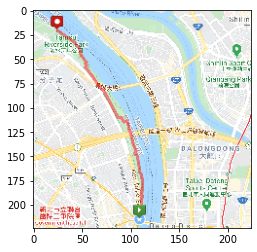

In [89]:
img_file = path_6
x6 = one_img_prep(img_file)
plt.imshow(x6[0])

In [90]:
pred_6 = model.predict(x6)
pred = pred_6
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.25 
Class 1 - park run      : 0.25 
Class 2 - riverside run : 0.38 
Class 3 - seaside run   : 0.11 

Highest pred probability: Class  2


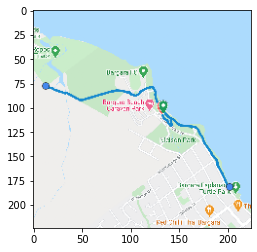

In [91]:
img_file = path_7
x7 = one_img_prep(img_file)
plt.imshow(x7[0])

In [92]:
pred_7 = model.predict(x7)
pred = pred_7
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.05 
Class 1 - park run      : 0.01 
Class 2 - riverside run : 0.09 
Class 3 - seaside run   : 0.84 

Highest pred probability: Class  3


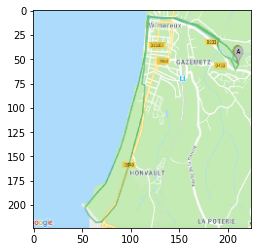

In [93]:
img_file = path_8
x8 = one_img_prep(img_file)
plt.imshow(x8[0])

In [94]:
pred_8 = model.predict(x8)
pred = pred_8
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.03 
Class 1 - park run      : 0.01 
Class 2 - riverside run : 0.08 
Class 3 - seaside run   : 0.88 

Highest pred probability: Class  3


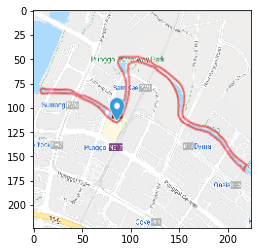

In [95]:
path_9 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/riverside_run/river_70.png'
img_file = path_9
x9 = one_img_prep(img_file)
plt.imshow(x9[0])

In [96]:
pred_9 = model.predict(x9)
pred = pred_9
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.33 
Class 1 - park run      : 0.25 
Class 2 - riverside run : 0.32 
Class 3 - seaside run   : 0.10 

Highest pred probability: Class  0


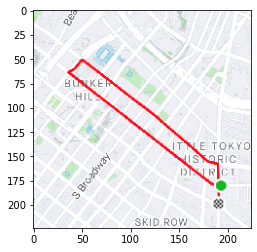

In [97]:
path_10 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/city_run/city_92.png'
img_file = path_10
x10 = one_img_prep(img_file)
plt.imshow(x10[0])

In [98]:
pred_10 = model.predict(x10)
pred = pred_10
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.35 
Class 1 - park run      : 0.29 
Class 2 - riverside run : 0.28 
Class 3 - seaside run   : 0.08 

Highest pred probability: Class  0


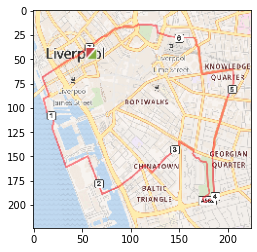

In [99]:
path_11 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/city_run/city_118.png'
img_file = path_11
x11 = one_img_prep(img_file)
plt.imshow(x11[0])

In [100]:
pred_11 = model.predict(x11)
pred = pred_11
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.31 
Class 1 - park run      : 0.31 
Class 2 - riverside run : 0.29 
Class 3 - seaside run   : 0.09 

Highest pred probability: Class  0


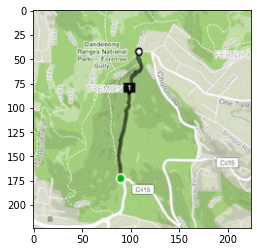

In [101]:
path_12 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/park_run/park_56.png'
img_file = path_12
x12 = one_img_prep(img_file)
plt.imshow(x12[0])

In [102]:
pred_12 = model.predict(x12)
pred = pred_12
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.23 
Class 1 - park run      : 0.65 
Class 2 - riverside run : 0.10 
Class 3 - seaside run   : 0.02 

Highest pred probability: Class  1


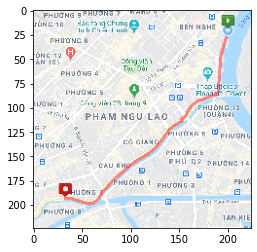

In [103]:
path_13 = '/Users/carlamoestafa/Documents/GitHub/project-5/running_routes/test/riverside_run/river_97.png'
img_file = path_13
x13 = one_img_prep(img_file)
plt.imshow(x13[0])

In [104]:
pred_13 = model.predict(x13)
pred = pred_13
print_pred_class(pred)

Predicted class probabilities: 
Class 0 - city run      : 0.33 
Class 1 - park run      : 0.24 
Class 2 - riverside run : 0.33 
Class 3 - seaside run   : 0.10 

Highest pred probability: Class  2
